<a href="https://colab.research.google.com/github/LeticiaKang/HappyVirus/blob/Second-Main/InceptionResnetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S,preprocess_input
from tensorflow.keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.applications import MobileNetV3Small

from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from time import perf_counter, sleep

import tensorflow_addons as tfa


In [50]:
# Data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=120, 
                                   horizontal_flip = True,)
# width_shift_range=[-150, 150] 사진 자르기 ---- height_shift_range=[-150, 150] 높이 기준으로 자르기
# rotation_range=120 회전하기 ---- brightness_range=[0.1, 1.5] 색 바꾸기 0.1은 10%
# zoom_range=[0.3, 1.5] 확대 ---- shear_range=50 좌우 늘리기
print("start")

test_datagen = ImageDataGenerator(rescale = 1./255)

# Generate training and test sets
train_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/train',
                                                #  target_size = (224,224),
                                                 target_size = (299,299),
                                                 batch_size = 16,
                                                #  batch_size = 128,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/test',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 16,
                                            # batch_size = 128,
                                            class_mode = 'categorical')

val_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/val',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 16,
                                            # batch_size = 128,
                                            class_mode = 'categorical')
print("end")

start
Found 221 images belonging to 8 classes.
Found 73 images belonging to 8 classes.
Found 73 images belonging to 8 classes.
end


In [51]:
# Load the InceptionResNetV2 model with pre-trained weights
input_tensor = tf.keras.layers.Input(shape=(299, 299, 3))
base_model = InceptionResNetV2(weights='imagenet', include_top=False,input_tensor=input_tensor)

# Freeze the layers
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Add a GlobalAveragePooling layer
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(8, activation='softmax',)(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    
    metrics=['accuracy',
              tf.keras.metrics.Precision(),
              tf.keras.metrics.Recall(),
              tfa.metrics. F1Score(num_classes = 8,
                                  average='macro')]
)
print("1")

1


In [52]:
# Train the model on the data
# Validation_data – 모델에 대한 손실 평가 및 메트릭에 대해 고려할 데이터입니다.
# Class_weight - 는 클래스의 사전 인덱스를 손실 함수 계산에 추가로 사용되는 해당 float 또는 weight 값으로 매핑하기 위한 선택적 매개변수입니다.
start = perf_counter()
history = model.fit_generator(train_set, epochs = 20, validation_data = val_set)
end = perf_counter()
print(f"Time : {end-start}")

<ipython-input-52-53723f3bb7fc>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_set, epochs = 20, validation_data = val_set)


Epoch 1/20
14/14 [==============================] - 26s 1s/step - loss: 8.7127 - accuracy: 0.1991 - precision_5: 0.2025 - recall_5: 0.1448 - f1_score: 0.1959 - val_loss: 3.5148 - val_accuracy: 0.3562 - val_precision_5: 0.4000 - val_recall_5: 0.1918 - val_f1_score: 0.3052
Epoch 2/20
14/14 [==============================] - 12s 854ms/step - loss: 2.3591 - accuracy: 0.4344 - precision_5: 0.5918 - recall_5: 0.2624 - f1_score: 0.4291 - val_loss: 1.2002 - val_accuracy: 0.6301 - val_precision_5: 0.7805 - val_recall_5: 0.4384 - val_f1_score: 0.6207
Epoch 3/20
14/14 [==============================] - 12s 853ms/step - loss: 1.0247 - accuracy: 0.6697 - precision_5: 0.8197 - recall_5: 0.4525 - f1_score: 0.6713 - val_loss: 1.1520 - val_accuracy: 0.6164 - val_precision_5: 0.7241 - val_recall_5: 0.5753 - val_f1_score: 0.5986
Epoch 4/20
14/14 [==============================] - 12s 857ms/step - loss: 0.8092 - accuracy: 0.7240 - precision_5: 0.8125 - recall_5: 0.6471 - f1_score: 0.7262 - val_loss: 1.264

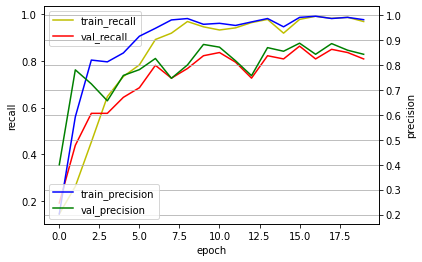

In [54]:
import matplotlib.pyplot as plt
fig, f1 = plt.subplots()

prec = f1.twinx()

f1.plot(history.history['recall_5'], 'y', label='train_recall')
f1.plot(history.history['val_recall_5'], 'r', label='val_recall')

prec.plot(history.history['precision_5'], 'b', label='train_precision')
prec.plot(history.history['val_precision_5'], 'g', label='val_precision')

f1.set_xlabel('epoch')
f1.set_ylabel('recall')
prec.set_ylabel('precision')

f1.legend(loc='upper left')
prec.legend(loc='lower left')

plt.grid()
plt.show()

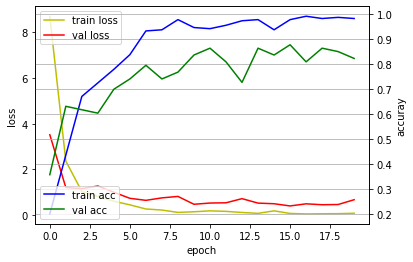

In [55]:
import matplotlib.pyplot as plt
fig, loss = plt.subplots()

acc = loss.twinx()

loss.plot(history.history['loss'], 'y', label='train loss')
loss.plot(history.history['val_loss'], 'r', label='val loss')

acc.plot(history.history['accuracy'], 'b', label='train acc')
acc.plot(history.history['val_accuracy'], 'g', label='val acc')

loss.set_xlabel('epoch')
loss.set_ylabel('loss')
acc.set_ylabel('accuray')

loss.legend(loc='upper left')
acc.legend(loc='lower left')

plt.grid()
plt.show()

In [56]:
# Evaluate the model on the test set
result= model.evaluate_generator(test_set) 

<ipython-input-56-e155823641e8>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result= model.evaluate_generator(test_set)


In [57]:
print('loss:', round(result[0], 5))
print('accuracy:', round(result[1], 5))
print('precision:', round(result[2], 5))
print('recall:', round(result[3], 5))
print('f1-score:', round(result[4], 5))

loss: 0.71182
accuracy: 0.83562
precision: 0.89706
recall: 0.83562
f1-score: 0.83329


In [61]:
# Train the model on the data
# Validation_data – 모델에 대한 손실 평가 및 메트릭에 대해 고려할 데이터입니다.
# Class_weight - 는 클래스의 사전 인덱스를 손실 함수 계산에 추가로 사용되는 해당 float 또는 weight 값으로 매핑하기 위한 선택적 매개변수입니다.
start = perf_counter()
history = model.fit_generator(train_set, epochs = 13, validation_data = val_set)
end = perf_counter()
print(f"Time : {end-start}")

<ipython-input-61-2a785e4d302c>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_set, epochs = 13, validation_data = val_set)


Epoch 1/13
14/14 [==============================] - 13s 895ms/step - loss: 0.0330 - accuracy: 0.9955 - precision_5: 0.9955 - recall_5: 0.9955 - f1_score: 0.9955 - val_loss: 0.4097 - val_accuracy: 0.8767 - val_precision_5: 0.8889 - val_recall_5: 0.8767 - val_f1_score: 0.8797
Epoch 2/13
14/14 [==============================] - 12s 858ms/step - loss: 0.0261 - accuracy: 0.9910 - precision_5: 0.9910 - recall_5: 0.9910 - f1_score: 0.9904 - val_loss: 0.5880 - val_accuracy: 0.8767 - val_precision_5: 0.8767 - val_recall_5: 0.8767 - val_f1_score: 0.8781
Epoch 3/13
14/14 [==============================] - 12s 853ms/step - loss: 0.0661 - accuracy: 0.9729 - precision_5: 0.9773 - recall_5: 0.9729 - f1_score: 0.9725 - val_loss: 0.5088 - val_accuracy: 0.8904 - val_precision_5: 0.8904 - val_recall_5: 0.8904 - val_f1_score: 0.8926
Epoch 4/13
14/14 [==============================] - 12s 841ms/step - loss: 0.0504 - accuracy: 0.9864 - precision_5: 0.9864 - recall_5: 0.9864 - f1_score: 0.9865 - val_loss: 0.

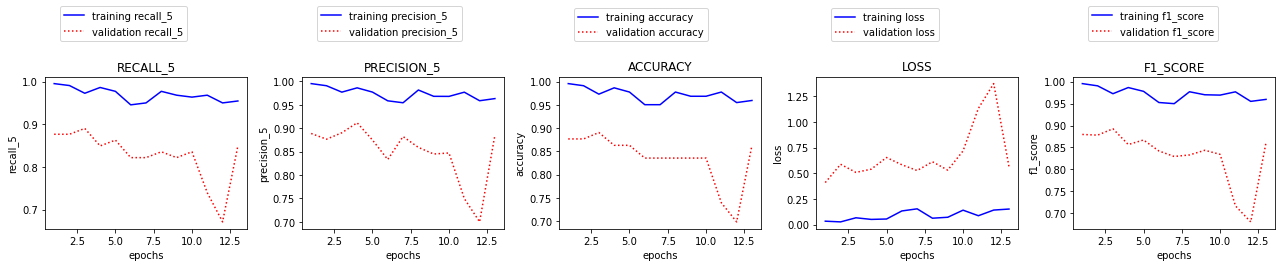

In [77]:
key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
plt.figure(figsize=(18, 4))
for idx , key in enumerate(key_value) :
    plt.subplot(1, len(key_value), idx+1)

    plt.title(f"{key.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{key.lower()}")
    value = history.history.get(key)
    val_value = history.history.get(f"val_{key}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {key}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {key}')
    plt.legend(loc='lower left', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)

plt.tight_layout()
plt.show()

---

In [ ]:
pred = model.predict(test_set)
y_preddd = []
for i in pred:
  y_pred.append(i.argmax())
print(y_pred)

5/5 [==============================] - 5s 410ms/step
[4, 1, 3, 4, 6, 6, 0, 4, 4, 2, 6, 1, 2, 1, 4, 6, 6, 3, 0, 5, 3, 6, 4, 5, 6, 1, 3, 3, 0, 5, 4, 4, 4, 1, 5, 2, 1, 3, 1, 6, 0, 1, 3, 2, 2, 6, 2, 1, 5, 0, 5, 0, 3, 6, 0, 0, 4, 1, 5, 5, 1, 5, 6, 2, 0, 4, 1, 7, 3, 1, 2, 5, 2]


In [ ]:
len(train_set.next())
train_set.next()

(array([[[[1.12157784e-01, 1.25522614e-01, 1.79538324e-01],
          [1.07477464e-01, 1.23163737e-01, 1.70222551e-01],
          [1.01289973e-01, 1.16976246e-01, 1.64035067e-01],
          ...,
          [1.51352823e-01, 1.67039096e-01, 2.65078306e-01],
          [1.50977403e-01, 1.66663691e-01, 2.64702916e-01],
          [1.56862751e-01, 1.72549024e-01, 2.70588249e-01]],
 
         [[1.16108440e-01, 1.30053058e-01, 1.80019841e-01],
          [1.05167083e-01, 1.20853357e-01, 1.65772706e-01],
          [1.00778438e-01, 1.16464712e-01, 1.62744552e-01],
          ...,
          [1.50754094e-01, 1.66440368e-01, 2.64479578e-01],
          [1.52174860e-01, 1.67861134e-01, 2.65900373e-01],
          [1.56862751e-01, 1.72549024e-01, 2.70588249e-01]],
 
         [[1.01666950e-01, 1.14555620e-01, 1.66635320e-01],
          [9.78530794e-02, 1.11888230e-01, 1.61733910e-01],
          [9.55886096e-02, 1.11274883e-01, 1.54810205e-01],
          ...,
          [1.50155351e-01, 1.65841624e-01, 2.6388

In [ ]:
y_pred = []
for i in pred:
  y_pred.append(i.argmax())
  # print(i.argmax())

In [ ]:
# import glob
# for a in glob.glob("/content/drive/MyDrive/테스트용/val")


v = np.array(y_pred)
v - test_set.classes


array([ 4,  1,  3,  4,  6,  6,  0,  4,  4,  1,  5,  0,  1,  0,  3,  5,  5,
        2, -2,  3,  1,  4,  2,  3,  4, -1,  0,  0, -3,  2,  1,  1,  1, -2,
        2, -1, -3, -1, -3,  2, -4, -3, -1, -2, -2,  2, -3, -4,  0, -5,  0,
       -5, -2,  1, -5, -5, -2, -5, -1, -1, -5, -1,  0, -4, -7, -3, -6,  0,
       -4, -6, -5, -2, -5])

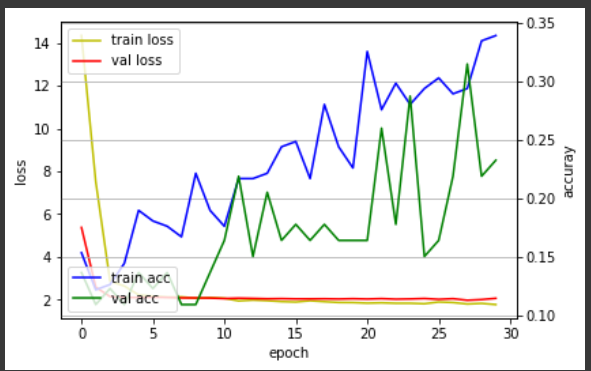

In [ ]:
v

In [ ]:
test_set.classes

In [ ]:
v

In [ ]:
from sklearn.metrics import f1_score

# Load the test labels
y_true = test_labels

# Convert the predictions to the class labels
y_pred = []
for i in pred:
    y_pred.append(i.argmax())

# Calculate the F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score: ", f1)

NameError: ignored